# First order Inch-worm test

Solving a non-interacting fermionic dimer system by hybridization expansion of one of the sites (here called the "bath" site).

In [1]:
import Test.@test

import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

import Keldysh; kd = Keldysh;
import KeldyshED; ked = KeldyshED;
import KeldyshED; op = KeldyshED.Operators;

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/hugstr/.julia/packages/PyPlot/XHEG0/src/init.jl:192


In [19]:
function plot2d(data; extent = nothing, vmin=-1., vmax=1.)
  # Correct for Row major order in Julia vs Column major in Python
  #data = transpose(data) # too clever, the arrays are sent as correct row/col major to matplotlib
  opt = Dict(:cmap=>"RdBu_r", :vmin=>vmin, :vmax=>vmax, :origin=>"upper", :extent=>extent)
  plt.figure(figsize=(8, 3))
  plt.subplot(1, 2, 1)
  plt.imshow(real(data); opt...)
  plt.colorbar()
  plt.subplot(1, 2, 2)
  plt.imshow(imag(data); opt...)
  plt.colorbar()
  plt.tight_layout()
  return
end;

In [3]:
β = 10. # Inverse temperature

μ = 0.1 + 0. * im # Chemical potential
V = -0.1 # Hybridization
ε = 0.1 # Bath site energy

H = - μ * op.n("0")
H_bath = ε * op.n("1")
H_hyb = V*(op.c_dag("0")*op.c("1") + op.c_dag("1")*op.c("0")) 

H_dimer = H + H_hyb + H_bath

# -- Real-time Kadanoff-Baym contour

contour = kd.twist(kd.FullContour(tmax=1., β=β));
nt = 10 
ntau = 30
grid = kd.FullTimeGrid(contour, nt, ntau);

# -- Bath hybridization function Δ(z, z')

soi_bath = ked.Hilbert.SetOfIndices([["1"]])
bidx = ked.Hilbert.IndicesType(["1"])
ed_bath = ked.EDCore(H_bath, soi_bath)
g_bath = ked.computegf(ed_bath, grid, bidx, bidx);

#Δ = V * g_bath * V

# Implement multiplication with scalar?

Δ = deepcopy(g_bath);
Δ.mat.data .*= V^2;
Δ.rm.data .*= V^2;
Δ.gtr.data .*= V^2;
Δ.les.data .*= V^2;

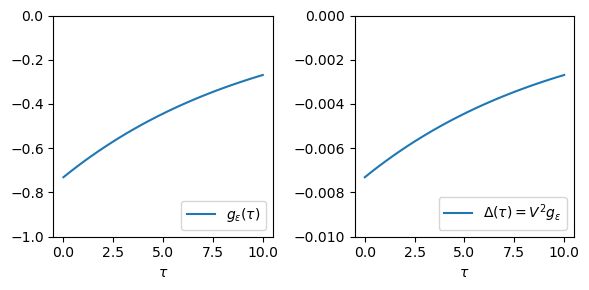

PyPlot.Figure(PyObject <Figure size 640x480 with 0 Axes>)

In [4]:
τ = kd.imagtimes(grid)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.plot(τ, g_bath[:matsubara], label=plt.L"$g_\varepsilon(\tau)$")
plt.xlabel(plt.L"$\tau$");
plt.legend(loc="lower right"); plt.ylim([-1., 0]);

plt.subplot(1, 2, 2)
plt.plot(τ, Δ[:matsubara], label=plt.L"$\Delta(\tau) = V^2 g_\varepsilon$")
plt.xlabel(plt.L"$\tau$");
plt.legend(loc="lower right"); plt.ylim([-0.01, 0]);
plt.tight_layout()

plt.figure()
#plot2d(g_bath.mat.data)

# Pseudo-particle strong coupling types

In [5]:
import QInchworm.ppgf

#is_scalar = G::kd.GenericTimeGF -> length(size(G)) == 2
PPGFTimeGF = Vector{kd.GenericTimeGF}
#Operator = op.OperatorExpr{T} where T
Operator = op.RealOperatorExpr

function is_canonical(O::Operator)
    return length(O) == 1 && length(first(O.monomials)[1]) == 1
end

function to_canonical(O::Operator)
    @assert is_canonical(O)
    return first(O.monomials)[1].ops[1]
end

function kind(O::Operator)
    to_canonical(O).dagger && return +1
    return -1
end

function index(O::Operator)
    return to_canonical(O).indices
end

struct Interaction
    O1::Operator # Initial operator
    O2::Operator # Final operator
    Δ::kd.FullTimeGF{ComplexF64, true}
    function Interaction(O1::Operator, O2::Operator, Δ::kd.AbstractTimeGF{ComplexF64, true})
        f = (t1, t2) -> Δ[t1, t2]
        Δ_full = kd.FullTimeGF(f, ComplexF64, Δ.grid, 1, kd.fermionic, true)
        new(O1, O2, Δ_full)
    end
end

struct PPGFData
    β::Real
    ed::ked.EDCore
    grid::kd.FullTimeGrid
    interactions::Array{Interaction, 1}
    P0::PPGFTimeGF
    P0_lambda::PPGFTimeGF
    P::PPGFTimeGF
    function PPGFData(β::Real, ed::ked.EDCore, grid::kd.FullTimeGrid, interactions::Array{Interaction, 1})
        P0 = ppgf.atomic_ppgf(grid, ed)
        P0_lambda = deepcopy(P0)
        P = deepcopy(P0)
        for P_s in P
            #P_s.data *= 0.
            P_s = zero(P_s)
        end
        new(β, ed, grid, interactions, P0, P0_lambda, P)
    end    
end

┌ Info: Precompiling QInchworm [c1b6c5a0-2f71-4f50-a75d-692762eff855]
└ @ Base loading.jl:1317
┌ Warning: Package QInchworm does not have Test in its dependencies:
│ - If you have QInchworm checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with QInchworm
└ Loading Test into QInchworm from project dependency, future warnings for QInchworm are suppressed.


# Equilibrium solution

## First order Inch-worm approximation

The dressed pseudo-particle propagator has the form

$$
G(\tau_f - 0) = 
G_0(\tau_f - \tau_w) \cdot G(\tau_w - 0) 
\\ + 
\sum_{ab} \int_{\tau_w}^{\tau_f} d\tau_2 \, \int_0^{\tau_w} d\tau_1 \, 
(-i)\Delta_{ab}(\tau_2 - \tau_1)
\left[ 
 G_0(\tau_f - \tau_2) c^\dagger_a(\tau_2) G_0(\tau_2 - \tau_w) 
 \cdot 
 G(\tau_w - \tau_1) c_b(\tau_1) G(\tau_1 - 0)
\right]
\\ 
+ 
\sum_{ab} \int_{\tau_w}^{\tau_f} d\tau_2 \, \int_0^{\tau_w} d\tau_1 \, 
(-i)\Delta_{ab}(\tau_2 - \tau_1)
\left[ 
 G_0(\tau_f - \tau_2) c_b(\tau_2) G_0(\tau_2 - \tau_w) 
 \cdot 
 G(\tau_w - \tau_1) c^\dagger_a(\tau_1) G(\tau_1 - 0)
\right]
$$

NB! To get the Matsubara component of $\Delta(\tau)$ from `Keldysh.jl` the values have to be scaled with $(-i)$

Here we restrict $\tau_f$ and $\tau_w$ (worm-time) to always be separated by a single time step, i.e. $\tau_f - \tau_w = \Delta \tau$.

The integrals are approximated using first order Riemann summation according to 

$$
\int_{\tau_w}^{\tau_f} d\tau_2 \, \int_0^{\tau_w} d\tau_1 \, 
(-i)\Delta(\tau_2 - \tau_1)
\left[ 
 G_0(\tau_f - \tau_2) c^\dagger(\tau_2) G_0(\tau_2 - \tau_w) 
 \cdot 
 G(\tau_w - \tau_1) c(\tau_1) G(\tau_1 - 0)
\right]
\\
\approx
(\Delta \tau)^2 \sum_{\tau_1=0}^{\tau_w} \, 
(-i)\Delta(\tau_f - \tau_1)
\left[ 
 c^\dagger(\tau_f) G_0(\tau_f - \tau_w) 
 \cdot 
 G(\tau_w - \tau_1) c(\tau_1) G(\tau_1 - 0)
\right]
$$

In [6]:
function inch_equilibrium!(d::PPGFData)

    for P_s in d.P
        #P_s.data .*= 0.
        P_s = zero(P_s)
    end
        
    ppgf.set_ppgf_initial_conditions(d.P)

    tau_grid = d.grid[kd.imaginary_branch]
    τ_0 = tau_grid[1]
    τ_beta = tau_grid[end]
    
    Δτ = -imag(tau_grid[2].bpoint.val - tau_grid[1].bpoint.val)

    I = d.interactions[1] # FIXME
    
    for (fidx, τ_f) in enumerate(tau_grid[2:end])
        τ_w = tau_grid[fidx]

        for (s0, P_s) in enumerate(d.P)
        
            # Zeroth order contrib
            val = -im * im^2 * d.P0[s0][τ_f, τ_w] * d.P[s0][τ_w, τ_0]
        
            # First order contrib -- verticies at τ_f and τ_1
            for τ_1 in tau_grid[1:fidx]
                
                # FWD hyb ins: \beta --c+--\tau_w--c-- \tau
                begin
                    vert_a = (τ_1, kind(I.O1), index(I.O1))
                    vert_b = (τ_f, kind(I.O2), index(I.O2))
                    p1, s1 = ppgf.operator_product(ed, d.P, s0, τ_0, τ_w, [vert_a])
                    if s1 > -1
                    p2, s2 = ppgf.operator_product(ed, d.P0, s1, τ_w, τ_f, [vert_b])
                        if s2 == s0
                            val += Δτ^2 * p2 * p1 * I.Δ[τ_f, τ_1]
                        end
                    end
                end
            
                # BWD hyb ins: \beta --c--\tau_w--c+-- \tau
                begin
                    vert_a = (τ_1, kind(I.O2), index(I.O2))
                    vert_b = (τ_f, kind(I.O1), index(I.O1))
                    p1, s1 = ppgf.operator_product(d.ed, d.P, s0, τ_0, τ_w, [vert_a])
                    if s1 > -1
                        p2, s2 = ppgf.operator_product(d.ed, d.P0, s1, τ_w, τ_f, [vert_b])
                        if s2 == s0
                            val += -Δτ^2 * p2 * p1 * I.Δ[τ_1, τ_f, false]
                        end
                    end
                end
                    
            end # τ_1
            
            ppgf.set_matsubara(P_s, τ_f, val)

        end # s0
    end # τ_f

    Z = ppgf.partition_function(d.P)
    λ = log(Z) / d.β

    ppgf.normalize(d.P, d.β);

    Z_0 = ked.partition_function(d.ed, d.β)
    λ_0 = log(Z_0) / d.β

    # -- Apply lambda shift on P0
    d.P0_lambda .= ppgf.atomic_ppgf(d.grid, d.ed, real(λ_0 + λ));    
end


soi = KeldyshED.Hilbert.SetOfIndices([["0"]])
ed = KeldyshED.EDCore(H, soi)

Oi = op.c("0")
Of = op.c_dag("0")
println(Oi)
println(typeof(Oi))
I = Interaction(Oi, Of, Δ)

d = PPGFData(β, ed, grid, [I]);

inch_equilibrium!(d);

1.0*c("0")
KeldyshED.Operators.RealOperatorExpr


In [7]:
τ_i = grid[kd.imaginary_branch][1]
τ_f = grid[kd.imaginary_branch][end]

println(d.P[1][τ_f, τ_i])
println(d.P[2][τ_f, τ_i])
println(d.P[1][τ_f, τ_i] + d.P[2][τ_f, τ_i])

@test d.P[1][τ_f, τ_i] + d.P[2][τ_f, τ_i] ≈ [-im]
@test d.P[1][τ_f, τ_i][1, 1] ≈ 0.0 - 0.7105404445143371im
@test d.P[2][τ_f, τ_i][1, 1] ≈ 0.0 - 0.289459555485663im

ComplexF64[0.0 - 0.710540444514337im]
ComplexF64[0.0 - 0.28945955548566293im]
ComplexF64[0.0 - 0.9999999999999999im]


Test Passed

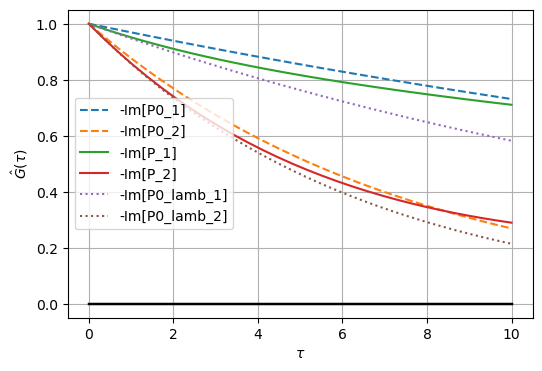

In [8]:
plt.figure(figsize=(6, 4))

for (s, P0_s) in enumerate(d.P0)
    p0_s = P0_s[kd.imaginary_branch, kd.imaginary_branch]
    p0_s = vcat(p0_s[:, 1]...)
    plt.plot(τ, -imag(p0_s), "--", label="-Im[P0_$(s)]")
    plt.plot(τ, real(p0_s), "-k")
end

for (s, P_s) in enumerate(d.P)
    p_s = P_s[kd.imaginary_branch, kd.imaginary_branch]
    p_s = vcat(p_s[:, 1]...)
    plt.plot(τ, -imag(p_s), "-", label="-Im[P_$(s)]")
    plt.plot(τ, real(p_s), "-k")
end

for (s, P_s) in enumerate(d.P0_lambda)
    p_s = P_s[kd.imaginary_branch, kd.imaginary_branch]
    p_s = vcat(p_s[:, 1]...)
    plt.plot(τ, -imag(p_s), ":", label="-Im[P0_lamb_$(s)]")
    plt.plot(τ, real(p_s), "-k")
end

plt.xlabel(plt.L"$\tau$")
plt.ylabel(plt.L"$\hat{G}(\tau)$");
plt.legend(); 
#plt.ylim([0, 1.1]);
plt.grid(true)

# Real-time 1st order Inching

In [10]:
function inch_real_time_first_order(G0, G, N, z_i, z_w, z_f, Δτ, Δt)
    
    I = d.interactions[1] # FIXME
    oidx = index(I.O1)
    
    for (s0, (G_s, n)) in enumerate(zip(G, N))

        # Zeroth order contrib
        val = -im * im^2 * G[s0][z_f, z_w] * G0[s0][z_w, z_i]
        
        # First order contrib -- verticies at τ_f and τ_1
        for z_1 in grid[z_w.cidx:z_f.cidx]

            Δz_1 = z_1.bpoint.domain == kd.imaginary_branch ? Δτ : Δt
            
            # FWD hyb ins: z_f --c+(z_1)--z_w--c(z_i)-- z_i
            begin
                vert_a = (z_i, kind(I.O1), index(I.O1))
                vert_b = (z_1, kind(I.O2), index(I.O2))
                p1, s1 = ppgf.operator_product(ed, G0, s0, z_i, z_w, [vert_a])
                if s1 > -1
                    p2, s2 = ppgf.operator_product(ed, G, s1, z_w, z_f, [vert_b])
                    if s2 == s0
                        val += -Δt * Δz_1 * p2 * p1 * Δ[z_1, z_i]
                    end
                end                
            end
            
            # BWD hyb ins: z_f --c(z_1)--z_w--c+(z_i)-- z_i
            begin
                vert_a = (z_i, kind(I.O2), index(I.O2))
                vert_b = (z_1, kind(I.O1), index(I.O1))
                p1, s1 = ppgf.operator_product(ed, G0, s0, z_i, z_w, [vert_a])
                if s1 > -1
                    p2, s2 = ppgf.operator_product(ed, G, s1, z_w, z_f, [vert_b])
                    if s2 == s0
                        val += -Δt * Δz_1 * p2 * p1 * -Δ[z_i, z_1, false]
                    end
                end
            end
            
        end # z_1
        ppgf.set_ppgf_symmetric(G_s, n, z_f, z_i, val)
        
    end # s0
end


function inch_real_time!(d::PPGFData)
    ppgf.ppgf_real_time_initial_conditions(d.P, d.ed)

    N_op = ppgf.total_density_operator(ed)
    N = ppgf.operator_matrix_representation(N_op, ed)

    grid = d.grid

    grid_bwd = grid[kd.backward_branch]
    grid_im = grid[kd.imaginary_branch]
    grid_fwd = grid[kd.forward_branch]

    Δτ = -imag(grid_im[2].bpoint.val - grid_im[1].bpoint.val)
    Δt = grid_fwd[2].bpoint.val - grid_fwd[1].bpoint.val
    
    zb_i, zb_f = grid_bwd[1], grid_bwd[end]
    zf_i, zf_f = grid_fwd[1], grid_fwd[end]

    for z_i in grid[kd.backward_branch][end-1:-1:1]
        z_w = grid[z_i.cidx + 1]
        #println(z_i)
        #println(z_w)
        #println("----------")
        fidx = zf_i.cidx + zb_f.cidx - z_i.cidx
        zf = grid[zf_i.cidx + zb_f.cidx - z_i.cidx]
        @test z_i.bpoint.val ≈ zf.bpoint.val

        #for z_f in grid[z_w.idx:zf.idx]
        for z_f in grid[z_w.cidx:zb_f.cidx] # Debug!
            #println("----------")
            #println("--> ", z_f)
            #println(z1)
            #println("----------")
            #G[1][z_f, z_i] += (0.5 - 0.5im) * I
            #G[1][z_f, z_i] += (0.5 - 0.5im) * I
        
            inch_real_time_first_order(d.P0_lambda, d.P, N, z_i, z_w, z_f, Δτ, Δt)
        end
    end    
end


inch_real_time!(d)

@test ppgf.check_ppgf_real_time_symmetries(d.P, d.ed)

fi = grid[kd.forward_branch][1]
ff = grid[kd.forward_branch][end]

@test d.P[1][ff, fi][1, 1] ≈ -0.053568002346462175 - 0.9945189991807661im
@test d.P[2][ff, fi][1, 1] ≈ -0.153424373002968300 - 0.9866565474833044im

Test Passed

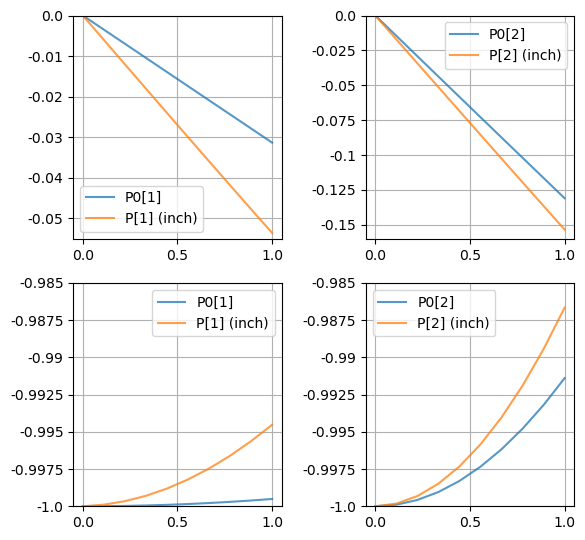

In [15]:
t = kd.realtimes(grid)

idx = grid[kd.backward_branch][end].cidx
fi = grid[kd.forward_branch][1].cidx
ff = grid[kd.forward_branch][end].cidx
ylim = [-1, -0.985]

plt.figure(figsize=(6, 5.5))

plt.subplot(2, 2, 1)
plt.plot(t, real(d.P0[1].data[1, 1, fi:ff, fi]), "-", label="P0[1]", alpha=0.75);
plt.plot(t, real(d.P[1].data[1, 1, fi:ff, fi]), "-", label="P[1] (inch)", alpha=0.75);
plt.legend();
plt.grid(true);
tick = -0.05:0.01:0.0
plt.yticks(tick, tick)
plt.ylim([-0.055, 0]);

plt.subplot(2, 2, 2)
plt.plot(t, real(d.P0[2].data[1, 1, fi:ff, fi]), "-", label="P0[2]", alpha=0.75);
plt.plot(t, real(d.P[2].data[1, 1, fi:ff, fi]), "-", label="P[2] (inch)", alpha=0.75);
plt.legend();
plt.grid(true);
#plt.ylim(ylim);
tick = -0.15:0.025:0.0
plt.yticks(tick, tick)
plt.ylim([-0.16, 0]);

plt.subplot(2, 2, 3)
plt.plot(t, imag(d.P0[1].data[1, 1, fi:ff, fi]), "-", label="P0[1]", alpha=0.75);
plt.plot(t, imag(d.P[1].data[1, 1, fi:ff, fi]), "-", label="P[1] (inch)", alpha=0.75);
plt.legend();
plt.grid(true);
tick = -1.:0.0025:0.0
plt.yticks(tick, tick)
plt.ylim(ylim);

plt.subplot(2, 2, 4)
plt.plot(t, imag(d.P0[2].data[1, 1, 1:idx, 1]), "-", label="P0[2]", alpha=0.75);
plt.plot(t, imag(d.P[2].data[1, 1, 1:idx, 1]), "-", label="P[2] (inch)", alpha=0.75);
plt.legend();
plt.grid(true);
tick = -1.:0.0025:0.0
plt.yticks(tick, tick)
plt.ylim(ylim);

# -- 

plt.tight_layout()

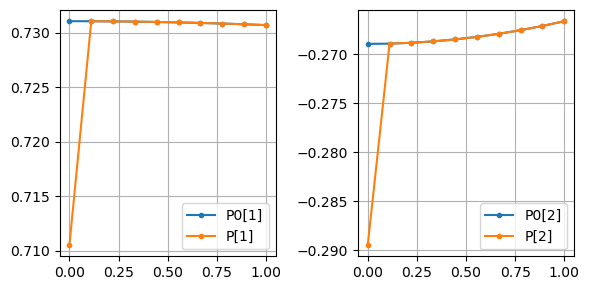

In [17]:
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.plot(t, imag(d.P0[1].data[1, 1, fi:ff, idx]), ".-", label="P0[1]");
plt.plot(t, imag(d.P[1].data[1, 1, fi:ff, idx]), ".-", label="P[1]");
plt.legend();
plt.grid(true);
#plt.ylim(ylim);

plt.subplot(1, 2, 2)
plt.plot(t, imag(d.P0[2].data[1, 1, fi:ff, idx]), ".-", label="P0[2]");
plt.plot(t, imag(d.P[2].data[1, 1, fi:ff, idx]), ".-", label="P[2]");
plt.legend();
plt.grid(true);
#plt.ylim(ylim);
plt.tight_layout()

In [24]:
vmax = maximum(abs.(d.P0[2].data[1, 1, :, :] - d.P[2].data[1, 1, :, :]))
println(vmax)

0.03413123792591288


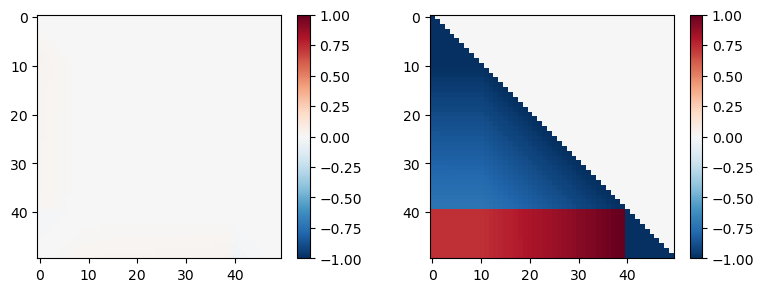

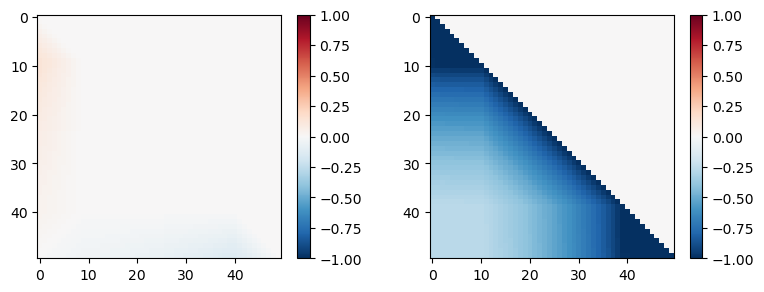

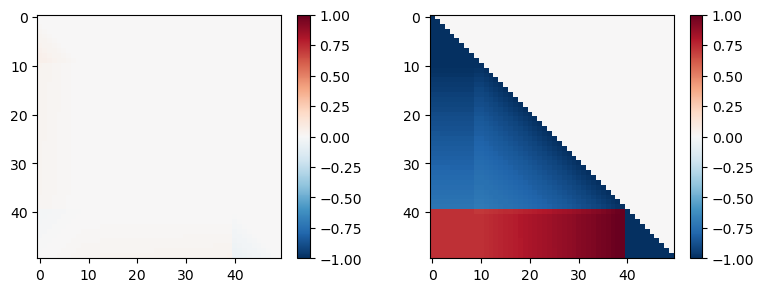

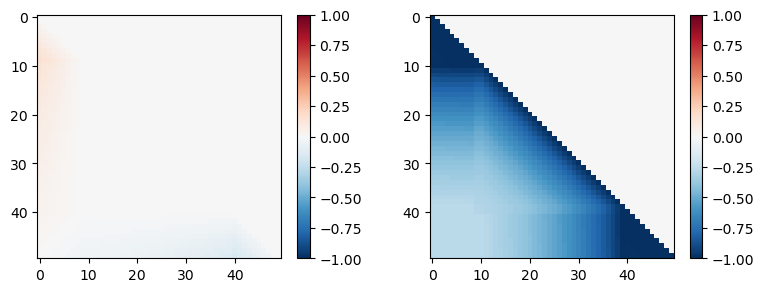

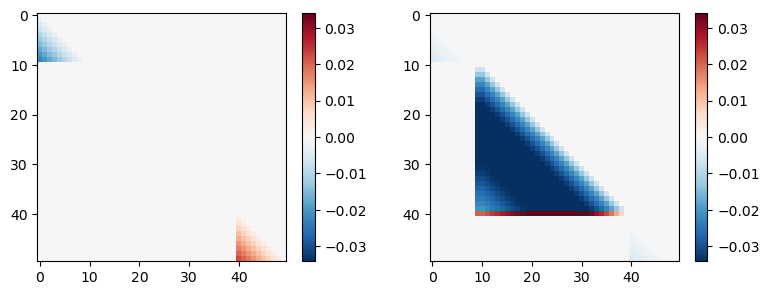

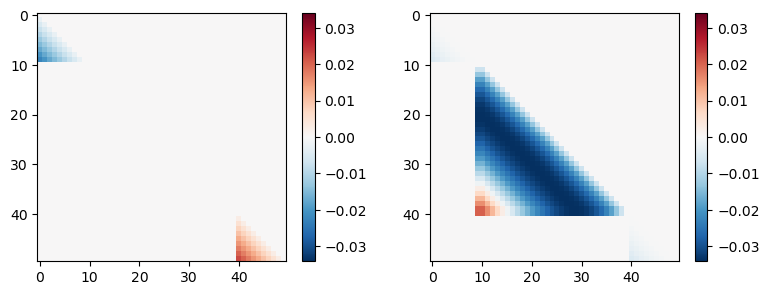

In [25]:
plot2d(d.P0[1].data[1, 1, :, :])
plot2d(d.P0[2].data[1, 1, :, :])
plot2d(d.P[1].data[1, 1, :, :])
plot2d(d.P[2].data[1, 1, :, :])
plot2d(d.P0[1].data[1, 1, :, :] - d.P[1].data[1, 1, :, :], vmin=-vmax, vmax=vmax)
plot2d(d.P0[2].data[1, 1, :, :] - d.P[2].data[1, 1, :, :], vmin=-vmax, vmax=vmax)